<a href="https://colab.research.google.com/github/VastSeaL/otter/blob/main/OtterMotionLstm_v2_RMSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This version add current speed and direction. Use loss RMSE


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive
!ls

/content/drive/MyDrive
'Colab Notebooks'   Dataset   ottermotion.csv   output.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [4]:
import numpy as np
import torch
import random

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(87)

In [5]:
data = pd.read_csv("ottermotion.csv")
data

,t,n1,n2,u,v,r,psi,beta
0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.01,0.020944,2.581787,0.018778,0.014509,-0.002631,0.000000,0.011436
2,0.02,0.041888,2.581787,0.037040,0.028563,-0.005069,0.000000,0.011442
3,0.03,0.062832,2.581787,0.054766,0.042175,-0.007331,0.000000,0.011438
4,0.04,0.083776,2.581787,0.071943,0.055356,-0.009432,-0.000150,0.011435
...,...,...,...,...,...,...,...,...
29996,299.96,-0.083776,-54.640496,-2.071331,-0.865796,0.059200,-2.912430,0.006910
29997,299.97,-0.062832,-54.640496,-2.071764,-0.864715,0.059194,-2.911838,0.006901
29998,299.98,-0.041888,-54.640496,-2.072196,-0.863632,0.059189,-2.911246,0.006892
29999,299.99,-0.020944,-54.640496,-2.072627,-0.862550,0.059184,-2.910654,0.006883


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[Info]: Use {device} now!")

[Info]: Use cpu now!


In [7]:
data['t']

0          0.00
1          0.01
2          0.02
3          0.03
4          0.04
          ...  
29996    299.96
29997    299.97
29998    299.98
29999    299.99
30000    300.00
Name: t, Length: 30001, dtype: float64

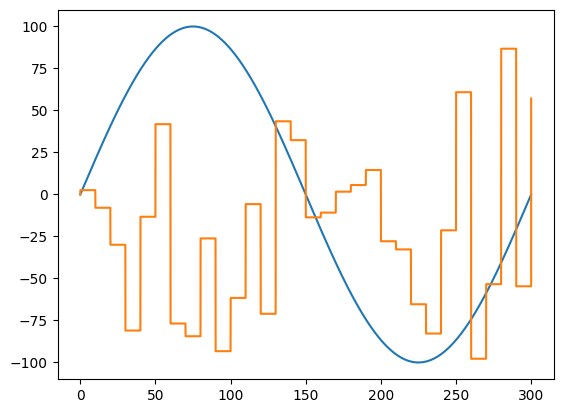

In [8]:
# data['t'] = pd.to_datetime(data['t'])
plt.plot(data['t'],data['n1'],data['t'],data['n2'])

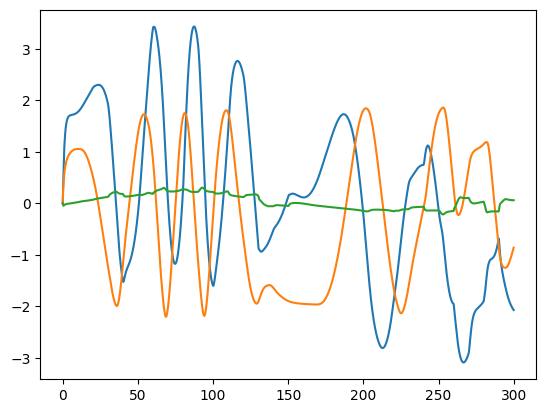

In [9]:
plt.plot(data['t'],data['u'],data['t'],data['v'],data['t'],data['r'])

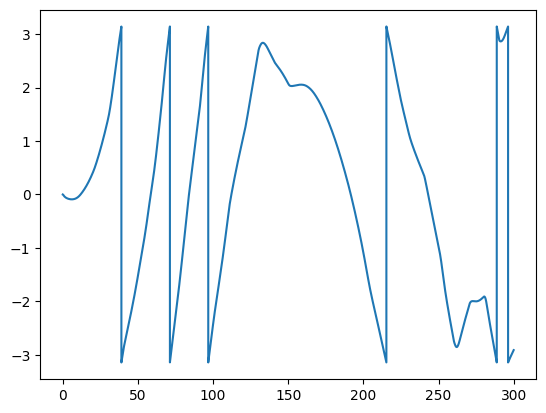

In [10]:
plt.plot(data['t'],data['psi'])

创建时间窗口数据

In [11]:
from copy import deepcopy as dc
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  # df['date'] = pd.to_datetime(df['date'])

  df.set_index('t', inplace=True)

  for i in range(1, n_steps+1):
    df[f'u(t-{i})'] = df['u'].shift(i)
    df[f'v(t-{i})'] = df['v'].shift(i)
    df[f'r(t-{i})'] = df['r'].shift(i)
    df[f'psi(t-{i})'] = df['psi'].shift(i)
    df[f'beta(t-{i})'] = df['beta'].shift(i)

  df.dropna(inplace=True)

  return df

lookback = 3
data = prepare_dataframe_for_lstm(data, lookback)
data

,n1,n2,u,v,r,psi,beta,u(t-1),v(t-1),r(t-1),...,u(t-2),v(t-2),r(t-2),psi(t-2),beta(t-2),u(t-3),v(t-3),r(t-3),psi(t-3),beta(t-3)
t,,,,,,,,,,,,,,,,,,,,,
0.03,0.062832,2.581787,0.054766,0.042175,-0.007331,0.000000,0.011438,0.037040,0.028563,-0.005069,...,0.018778,0.014509,-0.002631,0.000000,0.011436,0.000000,0.000000,0.000000,0.000000,0.000000
0.04,0.083776,2.581787,0.071943,0.055356,-0.009432,-0.000150,0.011435,0.054766,0.042175,-0.007331,...,0.037040,0.028563,-0.005069,0.000000,0.011442,0.018778,0.014509,-0.002631,0.000000,0.011436
0.05,0.104720,2.581787,0.088567,0.068115,-0.011387,-0.000245,0.011433,0.071943,0.055356,-0.009432,...,0.054766,0.042175,-0.007331,0.000000,0.011438,0.037040,0.028563,-0.005069,0.000000,0.011442
0.06,0.125664,2.581787,0.104640,0.080465,-0.013210,-0.000359,0.011433,0.088567,0.068115,-0.011387,...,0.071943,0.055356,-0.009432,-0.000150,0.011435,0.054766,0.042175,-0.007331,0.000000,0.011438
0.07,0.146608,2.581787,0.120170,0.092415,-0.014915,-0.000492,0.011435,0.104640,0.080465,-0.013210,...,0.088567,0.068115,-0.011387,-0.000245,0.011433,0.071943,0.055356,-0.009432,-0.000150,0.011435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299.96,-0.083776,-54.640496,-2.071331,-0.865796,0.059200,-2.912430,0.006910,-2.070898,-0.866878,0.059205,...,-2.070463,-0.867959,0.059210,-2.913614,0.006928,-2.070028,-0.869039,0.059216,-2.914207,0.006938
299.97,-0.062832,-54.640496,-2.071764,-0.864715,0.059194,-2.911838,0.006901,-2.071331,-0.865796,0.059200,...,-2.070898,-0.866878,0.059205,-2.913022,0.006919,-2.070463,-0.867959,0.059210,-2.913614,0.006928
299.98,-0.041888,-54.640496,-2.072196,-0.863632,0.059189,-2.911246,0.006892,-2.071764,-0.864715,0.059194,...,-2.071331,-0.865796,0.059200,-2.912430,0.006910,-2.070898,-0.866878,0.059205,-2.913022,0.006919


In [12]:
data2 = data[['n1','n2','u(t-1)','u(t-2)','u(t-3)','v(t-1)','v(t-2)','v(t-3)','r(t-1)','r(t-2)','r(t-3)','psi(t-1)','psi(t-2)','psi(t-3)','u','v','r','psi']]
data2

,n1,n2,u(t-1),u(t-2),u(t-3),v(t-1),v(t-2),v(t-3),r(t-1),r(t-2),r(t-3),psi(t-1),psi(t-2),psi(t-3),u,v,r,psi
t,,,,,,,,,,,,,,,,,,
0.03,0.062832,2.581787,0.037040,0.018778,0.000000,0.028563,0.014509,0.000000,-0.005069,-0.002631,0.000000,0.000000,0.000000,0.000000,0.054766,0.042175,-0.007331,0.000000
0.04,0.083776,2.581787,0.054766,0.037040,0.018778,0.042175,0.028563,0.014509,-0.007331,-0.005069,-0.002631,0.000000,0.000000,0.000000,0.071943,0.055356,-0.009432,-0.000150
0.05,0.104720,2.581787,0.071943,0.054766,0.037040,0.055356,0.042175,0.028563,-0.009432,-0.007331,-0.005069,-0.000150,0.000000,0.000000,0.088567,0.068115,-0.011387,-0.000245
0.06,0.125664,2.581787,0.088567,0.071943,0.054766,0.068115,0.055356,0.042175,-0.011387,-0.009432,-0.007331,-0.000245,-0.000150,0.000000,0.104640,0.080465,-0.013210,-0.000359
0.07,0.146608,2.581787,0.104640,0.088567,0.071943,0.080465,0.068115,0.055356,-0.013210,-0.011387,-0.009432,-0.000359,-0.000245,-0.000150,0.120170,0.092415,-0.014915,-0.000492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299.96,-0.083776,-54.640496,-2.070898,-2.070463,-2.070028,-0.866878,-0.867959,-0.869039,0.059205,0.059210,0.059216,-2.913022,-2.913614,-2.914207,-2.071331,-0.865796,0.059200,-2.912430
299.97,-0.062832,-54.640496,-2.071331,-2.070898,-2.070463,-0.865796,-0.866878,-0.867959,0.059200,0.059205,0.059210,-2.912430,-2.913022,-2.913614,-2.071764,-0.864715,0.059194,-2.911838
299.98,-0.041888,-54.640496,-2.071764,-2.071331,-2.070898,-0.864715,-0.865796,-0.866878,0.059194,0.059200,0.059205,-2.911838,-2.912430,-2.913022,-2.072196,-0.863632,0.059189,-2.911246


In [13]:
motion_data = data2.to_numpy()
motion_data

array([[ 6.28318490e-02,  2.58178716e+00,  3.70402420e-02, ...,
         4.21750280e-02, -7.33075100e-03,  0.00000000e+00],
       [ 8.37757940e-02,  2.58178716e+00,  5.47658730e-02, ...,
         5.53555720e-02, -9.43158400e-03, -1.50454000e-04],
       [ 1.04719736e-01,  2.58178716e+00,  7.19431200e-02, ...,
         6.81154330e-02, -1.13867430e-02, -2.45046000e-04],
       ...,
       [-4.18879010e-02, -5.46404957e+01, -2.07176398e+00, ...,
        -8.63632470e-01,  5.91890210e-02, -2.91124589e+00],
       [-2.09439510e-02, -5.46404957e+01, -2.07219587e+00, ...,
        -8.62549928e-01,  5.91837980e-02, -2.91065389e+00],
       [ 0.00000000e+00,  5.71893940e+01, -2.07262694e+00, ...,
        -8.61467004e-01,  5.91786010e-02, -2.91006195e+00]])

In [14]:
motion_data.shape

(29998, 18)

In [15]:
X = motion_data[:,:-4]
Y = motion_data[:,-4:]
X.shape, Y.shape

((29998, 14), (29998, 4))

In [16]:
X

array([[ 6.28318490e-02,  2.58178716e+00,  3.70402420e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.37757940e-02,  2.58178716e+00,  5.47658730e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.04719736e-01,  2.58178716e+00,  7.19431200e-02, ...,
        -1.50454000e-04,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.18879010e-02, -5.46404957e+01, -2.07176398e+00, ...,
        -2.91183794e+00, -2.91243004e+00, -2.91302220e+00],
       [-2.09439510e-02, -5.46404957e+01, -2.07219587e+00, ...,
        -2.91124589e+00, -2.91183794e+00, -2.91243004e+00],
       [ 0.00000000e+00,  5.71893940e+01, -2.07262694e+00, ...,
        -2.91065389e+00, -2.91124589e+00, -2.91183794e+00]])

In [17]:
split_index = int(len(X) *0.9)

split_index

26998

In [18]:
X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y[:split_index]
Y_test = Y[split_index:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((26998, 14), (3000, 14), (26998, 4), (3000, 4))

In [19]:
X_train = X_train.reshape((-1, 14, 1))
X_test = X_test.reshape((-1, 14, 1))

Y_train = Y_train.reshape((-1,4))
Y_test = Y_test.reshape((-1,4))

X_train.shape, Y_train.shape

((26998, 14, 1), (26998, 4))

In [20]:
X_train

array([[[ 6.28318490e-02],
        [ 2.58178716e+00],
        [ 3.70402420e-02],
        ...,
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 8.37757940e-02],
        [ 2.58178716e+00],
        [ 5.47658730e-02],
        ...,
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 1.04719736e-01],
        [ 2.58178716e+00],
        [ 7.19431200e-02],
        ...,
        [-1.50454000e-04],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       ...,

       [[-5.88124081e+01],
        [-9.77838625e+01],
        [-2.92031075e+00],
        ...,
        [-2.10611977e+00],
        [-2.10718014e+00],
        [-2.10824016e+00]],

       [[-5.87954680e+01],
        [-9.77838625e+01],
        [-2.91937131e+00],
        ...,
        [-2.10505905e+00],
        [-2.10611977e+00],
        [-2.10718014e+00]],

       [[-5.87785252e+01],
        [-5.33773565e+01],
        [-2.91842951e+00],
        ...,
        

In [21]:
X_train = torch.Tensor(X_train).float()
Y_train = torch.Tensor(Y_train).float()
X_test = torch.Tensor(X_test).float()
Y_test = torch.Tensor(Y_test).float()

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([26998, 14, 1]),
 torch.Size([3000, 14, 1]),
 torch.Size([26998, 4]),
 torch.Size([3000, 4]))

In [22]:
from torch.utils.data import Dataset

class TimeSerialDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.Y[i]


train_dataset = TimeSerialDataset(X_train, Y_train)
test_dataset = TimeSerialDataset(X_test, Y_test)

In [23]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [24]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 14, 1]) torch.Size([16, 4])


In [25]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers, output_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                        batch_first=True)
    self.dropout = nn.Dropout(0.4)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(hidden_size, output_layers)

  def forward(self, x):
    batch_size = x.size(0)

    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out = self.relu(x)
    out, _ = self.lstm(x, (h0,c0))
    # out = self.relu(out)
    out = self.dropout(out)
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1,32,4,4)
model.to(device)
model


LSTM(
  (lstm): LSTM(1, 32, num_layers=4, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (relu): ReLU()
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [37]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch +1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    # print("*****---***")
    # print(output, y_batch)
    # print("*****---***")
    loss = loss_function(output, y_batch)
    RMSE_loss = torch.sqrt(loss)
    running_loss += RMSE_loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99: #print every 100 batches
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                            avg_loss_across_batches))
      running_loss = 0.0


In [38]:
def validate_one_epoch():
  model.eval()
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      RMSE_loss = torch.sqrt(loss)
      running_loss += RMSE_loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0: .3f}'.format(avg_loss_across_batches))
  print('*****************************************************')
  print()

In [39]:
Y_train

tensor([[ 5.4766e-02,  4.2175e-02, -7.3308e-03,  0.0000e+00],
        [ 7.1943e-02,  5.5356e-02, -9.4316e-03, -1.5045e-04],
        [ 8.8567e-02,  6.8115e-02, -1.1387e-02, -2.4505e-04],
        ...,
        [-2.9194e+00,  6.7027e-01,  1.0609e-01, -2.1051e+00],
        [-2.9184e+00,  6.7217e-01,  1.0613e-01, -2.1040e+00],
        [-2.9175e+00,  6.7406e-01,  1.0616e-01, -2.1029e+00]])

In [40]:
learning_rate = 0.005
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.320
Batch 200, Loss: 0.319
Batch 300, Loss: 0.323
Batch 400, Loss: 0.326
Batch 500, Loss: 0.328
Batch 600, Loss: 0.333
Batch 700, Loss: 0.322
Batch 800, Loss: 0.317
Batch 900, Loss: 0.328
Batch 1000, Loss: 0.318
Batch 1100, Loss: 0.334
Batch 1200, Loss: 0.314
Batch 1300, Loss: 0.315
Batch 1400, Loss: 0.328
Batch 1500, Loss: 0.310
Batch 1600, Loss: 0.319
Val Loss:  0.268
*****************************************************

Epoch: 2
Batch 100, Loss: 0.328
Batch 200, Loss: 0.339
Batch 300, Loss: 0.321
Batch 400, Loss: 0.313
Batch 500, Loss: 0.316
Batch 600, Loss: 0.324
Batch 700, Loss: 0.338
Batch 800, Loss: 0.322
Batch 900, Loss: 0.317
Batch 1000, Loss: 0.311
Batch 1100, Loss: 0.316
Batch 1200, Loss: 0.335
Batch 1300, Loss: 0.323
Batch 1400, Loss: 0.320
Batch 1500, Loss: 0.326
Batch 1600, Loss: 0.327
Val Loss:  0.301
*****************************************************

Epoch: 3
Batch 100, Loss: 0.315
Batch 200, Loss: 0.320
Batch 300, Loss: 0.321
Batch 400,

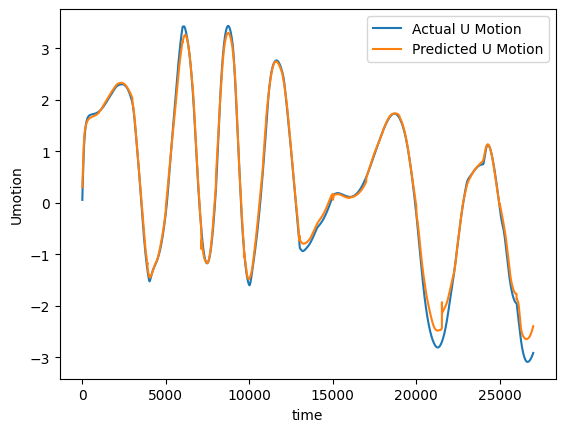

In [41]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(Y_train[:,0], label='Actual U Motion')
plt.plot(predicted[:,0], label='Predicted U Motion')
plt.xlabel('time')
plt.ylabel('Umotion')
plt.legend()
plt.show()

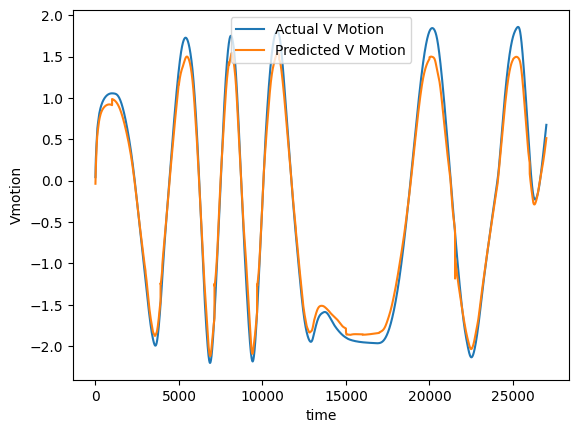

In [42]:
plt.plot(Y_train[:,1], label='Actual V Motion')
plt.plot(predicted[:,1], label='Predicted V Motion')
plt.xlabel('time')
plt.ylabel('Vmotion')
plt.legend()
plt.show()

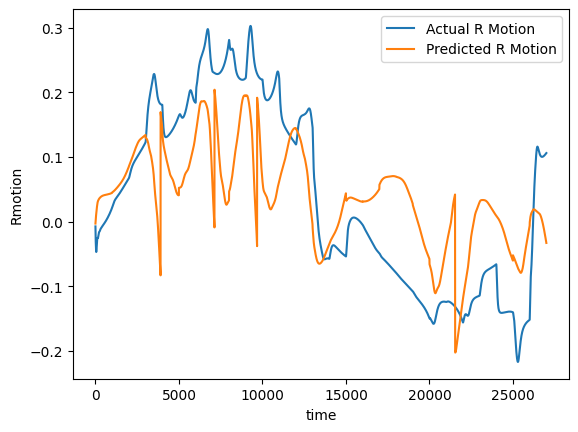

In [43]:
plt.plot(Y_train[:,2], label='Actual R Motion')
plt.plot(predicted[:,2], label='Predicted R Motion')
plt.xlabel('time')
plt.ylabel('Rmotion')
plt.legend()
plt.show()

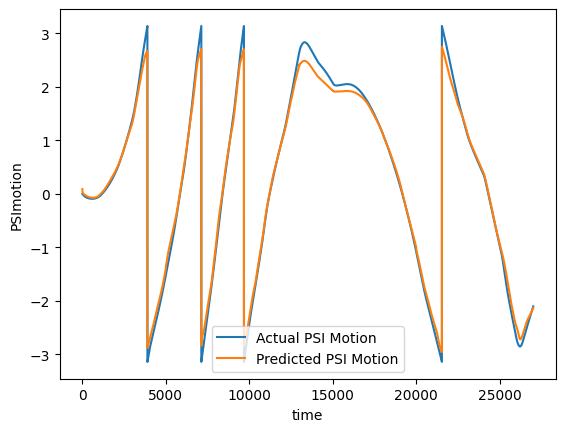

In [44]:
plt.plot(Y_train[:,3], label='Actual PSI Motion')
plt.plot(predicted[:,3], label='Predicted PSI Motion')
plt.xlabel('time')
plt.ylabel('PSImotion')
plt.legend()
plt.show()

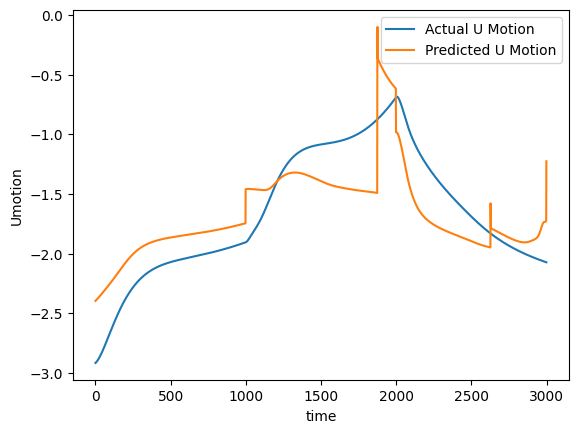

In [45]:
with torch.no_grad():
  predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(Y_test[:,0], label='Actual U Motion')
plt.plot(predicted[:,0], label='Predicted U Motion')
plt.xlabel('time')
plt.ylabel('Umotion')
plt.legend()
plt.show()

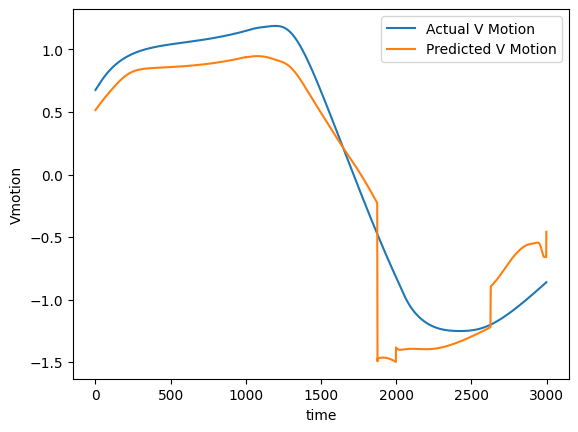

In [46]:
with torch.no_grad():
  predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(Y_test[:,1], label='Actual V Motion')
plt.plot(predicted[:,1], label='Predicted V Motion')
plt.xlabel('time')
plt.ylabel('Vmotion')
plt.legend()
plt.show()

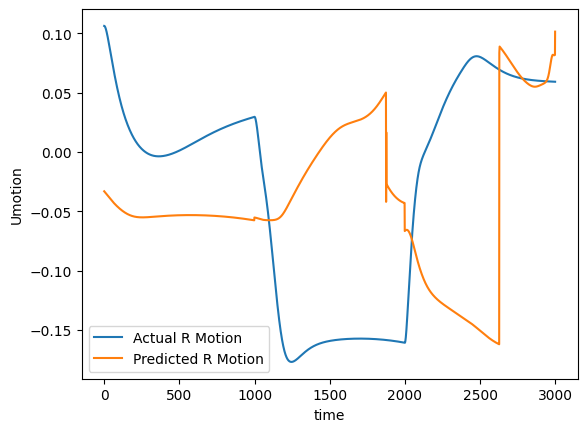

In [47]:
with torch.no_grad():
  predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(Y_test[:,2], label='Actual R Motion')
plt.plot(predicted[:,2], label='Predicted R Motion')
plt.xlabel('time')
plt.ylabel('Umotion')
plt.legend()
plt.show()